# Supplementary: Counts of differentially spliced exons per examined tissue

This notebook aggregates the results from the differential splicing from (**see** [figureXXX.ipynb](figure1.ipynb)), and more specifically the `limma::topTable()` output dataframes across all tissues in the GTEX cohort and generates summary statistics for the number of genes found to be statistically up or downregulated between male and female subjects.

 ---
 
 **Running this notebook**:
 
A few steps are needed before you can run this document on your own. The GitHub repository (https://github.com/TheJacksonLaboratory/sbas) of the project contains detailed instructions for setting up the environment in the **`dependencies/README.md`** document. Before starting with the analysis, make sure you have first completed the dependencies set up by following the instructions described there. If you have not done this already, you will need to close and restart this notebook before running it.

All paths defined in this Notebook are relative to the parent directory (repository). 

 ---


# Loading dependencies

In [99]:
library(dplyr)
library(tidyr)
library(reshape)
library(ggplot2)
library(piggyback)
library(snakecase)

# Retrieving the results from the Differential Splicing Events using [`ropensci/piggyback`](https://github.com/ropensci/piggyback)

This notebook requires as input data the limma `topTable()` objects from the Differential Gene Expression analysis (see [figureXXX.ipynb]()). We have archived the results from the notebook that generates the results using the method described by the author of the R package [`ropensci/piggyback`](https://github.com/ropensci/piggyback). We use the release named `diff_spliced` (Differential Spliced Exons) in the repo and can be accessed at [TheJacksonLaboratory/sbas/releases/tag/diff_spliced](https://github.com/TheJacksonLaboratory/sbas/releases/tag/diff_spliced). 

For using the [`ropensci/piggyback`](https://github.com/ropensci/piggyback) with private repositories, it is required that a `GITHUB_TOKEN` is stored as a variable in the R environment in which one is working. To generate such a token with sensible default permissions, the R package [usethis]() has a convenient function 

```R
# intall.packages("usethis")
usethis::browse_github_token()
```

This will redirect you to GitHub to create your own GitHub token. Once you have the token, you can use it to set up `.Renviron` by typing the following:

```R
Sys.setenv(GITHUB_TOKEN = "youractualtokenindoublequotes")
```

Then you sre ready to use the function [`piggyback::pb_download()`](https://docs.ropensci.org/piggyback/reference/pb_download.html) to retrieve the `dge.tar.gz` that contains the topTable objects written as .csv file for all 46 examined GTEX tissue cohorts.

---

***NOTE***

Avoid using the `.token` argument to share your token directly in the function as you might forget and push your code, along with your private GITHUB_TOKEN to GitHub. If that happens by mistake, it is advised you invalidate the token that has been exposed by accessing [this link](https://github.com/settings/tokens) and clicking `Delete`.

---

In [6]:
piggyback::pb_download(file = "results_sex_as_events.tar.gz",
                       dest = "../data",
                       repo = "TheJacksonLaboratory/sbas",
                       tag  = "rMATs.3.2.5.gencode.V30.GTEx.V8.DE.v.1.0",
                       show_progress = TRUE)
system("mv ../data/results_sex_as_events.tar.gz  ../data/diff_spliced.tar.gz", intern = TRUE)

tar_gz_top_table_diff_splicing_archive <- ("../data/diff_spliced.tar.gz")

if (!file.exists( tar_gz_top_table_diff_splicing_archive )) {
    
    message( paste0("Fetching ", basename(tar_gz_top_table_diff_splicing_archive) , " from GitHub .."))
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "diff_spliced.tar.gz",
                           dest = "../data",
                           repo = "TheJacksonLaboratory/sbas",
                           tag  = "diff_spliced",
                           show_progress = TRUE)
    message("Done!\n")
    
    message("Decompressing archive into folder ../data/diff_spliced ..")
    # Decompress in a folder tmp named dge
    system("mkdir -p ../data/diff_spliced && tar xvzf ../data/diff_spliced.tar.gz -C ../data/diff_spliced/", intern = TRUE)
    message("Done!\n")
}
if (file.exists("../data/diff_spliced.tar.gz ")) {
    message("File diff_spliced.tar.gz already available in ../data/ !\n")
    message("Decompressing archive into folder ../data/diff_spliced ..")
    # Decompress in a folder tmp named dge
    system("mkdir -p ../data/diff_spliced && tar xvzf ../data/diff_spliced.tar.gz -C ../data/diff_spliced/", intern = TRUE)
    message("Done!\n")
}


# pData_yarn_downloadGTExV8.csv
if (! (file.exists("../data/pData_yarn_downloadGTExV8.csv"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching pData_yarn_downloadGTExV8.csv from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "pData_yarn_downloadGTExV8.csv",
                           dest = "../data",
                           repo = "TheJacksonLaboratory/sbas",
                           tag  = "GTExV8.v1.0",
                           show_progress = TRUE)
    message("Done!\n")
}

# fromGTF.tar.gz
if (! (file.exists("../data/fromGTF.tar.gz"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching fromGTF.tar.gz from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "fromGTF.tar.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_gtf",
                           tag  = "rMATS.3.2.5.gencode.v30",
                           show_progress = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.tar.gz into ../data")
    system("mkdir -p ../data && tar xvfz ../data/fromGTF.tar.gz -C ../data", intern = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.*.txt.gz into ../data")
    system("gunzip  ../data/fromGTF*.txt.gz ", intern = TRUE)
    message("Done!\n")
}


Fetching diff_spliced.tar.gz from GitHub ..

All files up-to-date already


Done!


Decompressing archive into folder ../data/diff_spliced ..

Done!




# Create a list of named dataframes with the Differentially Spliced Exons `limma::topTable()`s

We will iterate over the list of named dataframes to collect summary statistics. More specifically, retrieve the count of:
- upregulated
- downregulated
- non significant

differentially spliced exons for the contrast males-females per tissue.

In [7]:
suffix_pattern   <- "*_DGE_sex_as_events.csv"
tables_folder    <- "../data/diff_spliced/"

tables_filepaths <- list.files(tables_folder, pattern = suffix_pattern, full.names = TRUE)
tables_filenames <- list.files(tables_folder, pattern = suffix_pattern, full.names = FALSE)

In [8]:
all_topTables <- lapply(tables_filepaths,read.csv)
names(all_topTables) <- gsub("_DGE_sex_as_events.csv","", tables_filenames, fixed = TRUE)

The list named `all_topTables` is the object that holds all the topTable dataframes from each tissue comparison:

In [9]:
length(all_topTables)

[1] 44

In [10]:
summary(all_topTables)

                                      Length Class      Mode
adipose_visceral_omentum              6      data.frame list
adrenal_gland                         6      data.frame list
artery_aorta                          6      data.frame list
artery_coronary                       6      data.frame list
artery_tibial                         6      data.frame list
bladder                               6      data.frame list
brain_amygdala                        6      data.frame list
brain_anterior_cingulate_cortex_ba_24 6      data.frame list
brain_caudate_basal_ganglia           6      data.frame list
brain_cerebellar_hemisphere           6      data.frame list
brain_cerebellum                      6      data.frame list
brain_cortex                          6      data.frame list
brain_frontal_cortex_ba_9             6      data.frame list
brain_hippocampus                     6      data.frame list
brain_hypothalamus                    6      data.frame list
brain_nucleus_accumbens_

In [11]:
head(all_topTables[[1]] , 2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XIST-10149,-7.142389,0.9941613,-48.32587,1.260076e-177,5.353307e-173,324.0275
XIST-10154,-6.826079,0.7901787,-46.60829,7.328131e-172,1.556642e-167,316.7197


# Loading the feature annotation tab seperated file `fromGTF.SE.txt`

In [12]:
fromGTF.SE <- read.csv("../data/fromGTF.SE.txt",sep = "\t")
fromGTF.SE[["ID"]] <- as.character(fromGTF.SE[["ID"]] )
head(fromGTF.SE)

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<chr>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,ENSG00000034152.18,MAP2K3,chr17,+,21287990,21288091,21284709,21284969,21295674,21295769
2,2,ENSG00000034152.18,MAP2K3,chr17,+,21303182,21303234,21302142,21302259,21304425,21304553
3,3,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21296085,21296143
4,4,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21298412,21298479
5,5,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21296085,21296143
6,6,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21298412,21298479


# Example with one topTable before iterating over all tissues

In [13]:
# Example topTable and name
topTable <- all_topTables[[1]]
name     <- names( all_topTables)[1]
name
head(topTable,2)

[1] "adipose_visceral_omentum"

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XIST-10149,-7.142389,0.9941613,-48.32587,1.260076e-177,5.353307e-173,324.0275
XIST-10154,-6.826079,0.7901787,-46.60829,7.328131e-172,1.556642e-167,316.7197


## Defining the thresholds for the double criterion filtering:

Criteria:
- Adjusted p-value < `p_value_cuttoff`
- Absolute FoldChange > `absFold_change_threshold`

----

***NOTE***

Defining higher in males or females based on the limma design matrix.
As we have used 1 for encoding the females and 2 for the males, our *reference level* for the contrast in the expression between males and females is 1, the females.


From the `limma` documentation:
>The level which is chosen for the *reference level* is the level which is contrasted against. By default, this is simply the first level alphabetically. We can specify that we want group 2 to be the reference level by either using the relevel function [..]

By convention, we could say that genes with positive log fold change, are higher in males, whereas the opposite holds true for the ones that are observed to have negative log fold change. 

---

In [15]:
adj.P.Val_threshold  <- 0.05
absFoldChange_cutoff <- 1.5
absFoldChange_cutoff

[1] 1.5

Replacing potential `NA` values in the `P.Value`, `adj.P.Val` to keep the columns numeric and avoid coersion.

In [16]:
# replacing NA p-values with p-value = 1
topTable$P.Value[is.na(topTable$P.Value)]     <- 1; 
topTable$adj.P.Val[is.na(topTable$adj.P.Val)] <- 1;

In [17]:
# Add helper variable dummy `FoldChange` variable. Use 2 as base of log, because this is the default from limma
# The following statement calculates a dummy fold change (how many times higher or lower)
# The minus symbol is a convention symbol only! to express eg. a fold change of 0.25 as -4, 4 times lower
topTable$FoldChange_dummy    <-   ifelse(topTable$logFC > 0, 2 ^ topTable$logFC, -1 / (2 ^ topTable$logFC))                    

# Add helper variable `abs_logFC`.
topTable$abs_logFC <- abs(topTable$logFC)

# Add helper variable `abundance` for up, down, non_signif
topTable$abundance                                                  <- "non_signif"
topTable$abundance[ ((topTable$logFC >   log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )) ]   <- "higher"
topTable$abundance[ ((topTable$logFC <  -log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )) ]   <- "lower"

In [18]:
dim(topTable[ topTable$abundance == "non_signif" ,])
dim(topTable[ topTable$abundance == "higher" ,])
dim(topTable[ topTable$abundance == "lower" ,])

[1] 42438     9

[1] 14  9

[1] 32  9

In [19]:
table(topTable$abundance)


    higher      lower non_signif 
        14         32      42438 

# Define a vector with the columns to keep in the annotated from GTF `topTable` object

In [20]:
#toKeep <- c("Geneid","logFC","FoldChange_dummy", "adj.P.Val", "abundance")
toKeep <- colnames(topTable)

In [21]:
head(topTable[ , colnames(topTable) %in% toKeep ],2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,FoldChange_dummy,abs_logFC,abundance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
XIST-10149,-7.142389,0.9941613,-48.32587,1.260076e-177,5.353307e-173,324.0275,-141.2776,7.142389,lower
XIST-10154,-6.826079,0.7901787,-46.60829,7.328131e-172,1.556642e-167,316.7197,-113.4630,6.826079,lower


# Annotate topTable with the fromGTF file

In [33]:
topTable$junctionGeneSymbol <- rownames(topTable)
topTable$symbol  <- sub("-[^-]+$","", topTable$junctionGeneSymbol)
topTable$ID <- sub("^.+-", "", topTable$junctionGeneSymbol)

In [34]:
head(topTable, 2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,FoldChange_dummy,abs_logFC,abundance,junctionGeneSymbol,symbol,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
XIST-10149,-7.142389,0.9941613,-48.32587,1.260076e-177,5.353307e-173,324.0275,-141.2776,7.142389,lower,XIST-10149,XIST,10149
XIST-10154,-6.826079,0.7901787,-46.60829,7.328131e-172,1.556642e-167,316.7197,-113.4630,6.826079,lower,XIST-10154,XIST,10154


In [25]:
name
dim(topTable)
dim(topTable  [ topTable$abundance != "non_signif",  ])
dim(topTable  [ ((abs(topTable$logFC > log2(absFoldChange_cutoff)) )  & (topTable$adj.P.Val <= adj.P.Val_threshold )) ,  ])
dim(topTable  [ ((abs(topTable$logFC < -log2(absFoldChange_cutoff)) )  & (topTable$adj.P.Val <= adj.P.Val_threshold )) ,  ])

[1] "adipose_visceral_omentum"

[1] 42484    12

[1] 46 12

[1] 14 12

[1] 32 12

In [29]:
expression_abundance <- t(table(topTable$abundance))
expression_abundance

      
       higher lower non_signif
  [1,]     14    32      42438

In [30]:
expression_abundance <- t(table(topTable$abundance))
signif <- as.data.frame.matrix(expression_abundance)

In [31]:
signif

higher,lower,non_signif
<int>,<int>,<int>
14,32,42438


In [36]:
annotatedTopTable <- dplyr::left_join(topTable, fromGTF.SE, by = "ID")

In [37]:
table(annotatedTopTable$abundance)


    higher      lower non_signif 
        14         32      42438 

In [38]:
head(annotatedTopTable)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,FoldChange_dummy,abs_logFC,abundance,junctionGeneSymbol,⋯,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,-7.142389,0.9941613,-48.325871,1.260076e-177,5.353307e-173,324.02755,-141.277585,7.142389,lower,XIST-10149,⋯,ENSG00000229807.11,XIST,chrX,-,73831065,73831274,73829067,73829231,73833237,73833374
2,-6.826079,0.7901787,-46.608288,7.328131e-172,1.556642e-167,316.71971,-113.463031,6.826079,lower,XIST-10154,⋯,ENSG00000229807.11,XIST,chrX,-,73831065,73831206,73829067,73829231,73833237,73833374
3,6.584646,0.8340215,43.521422,3.869817e-161,5.480177e-157,297.70972,95.978957,6.584646,higher,XIST-10152,⋯,ENSG00000229807.11,XIST,chrX,-,73830622,73830790,73829067,73829231,73831065,73831210
4,-2.887104,1.5312931,-21.602020,5.515682e-71,5.858206e-67,138.21741,-7.397839,2.887104,lower,XIST-10150,⋯,ENSG00000229807.11,XIST,chrX,-,73833237,73833374,73831065,73831274,73837439,73841474
5,-1.661346,1.3748820,-11.289854,4.058754e-26,3.448643e-22,46.00144,-3.163114,1.661346,lower,XIST-10155,⋯,ENSG00000229807.11,XIST,chrX,-,73822070,73822216,73820655,73821029,73826114,73827984
6,-1.360720,1.2477198,-9.942836,3.870273e-21,2.740411e-17,35.51915,-2.568132,1.360720,lower,XIST-10151,⋯,ENSG00000229807.11,XIST,chrX,-,73822070,73822233,73820655,73821029,73826114,73826301


To avoid errors in the cases that we might have none lower or none higher, and the matrix might be missing columns we will create a template data.frame and also add the column that might be missing if lower or higher genes is equal to 0.

In [39]:
signif_template <- structure(list(higher = integer(0), 
                                   lower = integer(0), 
                                   non_signif = integer(0)), 
                              row.names = integer(0), class = "data.frame")
signif_template

higher,lower,non_signif
<int>,<int>,<int>


In the for-loop we will check if both columns `lower`, `higher` are present, if not add the column and zero count to create the expected shape of the dataframe:

```R
signif <- as.data.frame.matrix(expression_abundance)
if(! ("higher" %in% colnames(signif))) { 
    
    signif$higher <- 0
}
if(! ("lower" %in% colnames(signif))) { 

    signif$lower <- 0
}
```

Now we can add some more summary statistics eg percentage of genes lower, higher or non-significantly different, 

In [40]:
signif$tissue <- name
signif$sum    <- signif$non_signif + signif$higher + signif$lower
toKeepInOrder <- c("tissue", "non_signif", "lower", "higher", "% lower", "% higher", "% non-signif")
signif$`% higher`     <-  round(signif$higher / signif$sum  * 100, 2)
signif$`% lower`      <-  round(signif$lower / signif$sum  * 100, 2)
signif$`% non-signif` <-  round(signif$non_signif / signif$sum  * 100, 2)
signif <- signif[, toKeepInOrder]
signif

tissue,non_signif,lower,higher,% lower,% higher,% non-signif
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
adipose_visceral_omentum,42438,32,14,0.08,0.03,99.89


# Summary table of differentially expressed genes between male and female acrosss tissues

Above we demonstrate for one example limma `topTable`. Let's now iterate over all tissue and create an aggregated table of counts of differentially expressed or non-significantly altered between the two sexes.

In [43]:
summary_signif <-structure(list(tissue = character(0), 
                            non_signif = integer(0), 
                            lower = integer(0),
                            higher = integer(0),
                            `% lower` = numeric(0), 
                            `% higher` = numeric(0), 
                            `% non-signif` = numeric(0)), 
                       row.names = integer(0), 
                       class = "data.frame")

signif_template <- structure(list(higher = integer(0), 
                                   lower = integer(0), 
                                   non_signif = integer(0)), 
                              row.names = integer(0), class = "data.frame")

signif_per_tissue <- structure(list(logFC = numeric(0), AveExpr = numeric(0), t = numeric(0), 
                        P.Value = numeric(0), adj.P.Val = numeric(0), B = numeric(0), 
                        initial_gene_id = character(0), gene_id = character(0), abs_logFC = numeric(0), 
                        FoldChange_dummy = numeric(0), abundance = character(0), 
                        GeneSymbol = character(0), Chromosome = character(0), Class = character(0), 
                        Strand = character(0), tissue = character(0)), row.names = integer(0), class = "data.frame")


for (i in seq_along(all_topTables)){
    topTable <- all_topTables[[i]]
    topTable$junctionGeneSymbol <- rownames(topTable)
    topTable$symbol  <- sub("-[^-]+$","", topTable$junctionGeneSymbol)
    topTable$ID <- sub("^.+-", "", topTable$junctionGeneSymbol)  
    topTable$splice_type  <- "SE"
    topTable$featurespace <- "sex_as_events"
    topTable <- dplyr::left_join(topTable, fromGTF.SE, by = "ID")
    name     <- names(all_topTables)[i] 
    # replacing NA p-values with p-value = 1
    topTable$P.Value[is.na(topTable$P.Value)]     <- 1; 
    topTable$adj.P.Val[is.na(topTable$adj.P.Val)] <- 1;
    topTable$abs_logFC <- abs(topTable$logFC)
    # Add helper variable dummy `FoldChange` variable. Use 2 as base of log, because this is the default from limma
    # The following statement calculates a dummy fold change (how many times higher or lower)
    # The minus symbol is a convention symbol only! to express eg. a fold change of 0.25 as -4, 4 times lower
    topTable$FoldChange_dummy    <-   ifelse(topTable$logFC > 0, 2 ^ topTable$logFC, -1 / (2 ^ topTable$logFC))                    

    # Add helper variable `abs_logFC`.
    topTable$abs_logFC <- abs(topTable$logFC)

    # Add helper variable `abundance` for up, down, non_signif
    topTable$abundance                                                  <- "non_signif"
    topTable$abundance[ ((topTable$logFC >   log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )) ]   <- "higher"
    topTable$abundance[ ((topTable$logFC <  -log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )) ]   <- "lower"
    topTable_signif <- topTable[ topTable$abundance != "non_signif", ]
    topTable_signif$tissue <- name
    signif_per_tissue <- rbind(signif_per_tissue, topTable_signif )
    data.table::fwrite(file = paste0("../data/signif_", snakecase::to_snake_case(name), ".csv"), topTable_signif)
    expression_abundance <- t(table(topTable$abundance))
    signif <- as.data.frame.matrix(expression_abundance)
    if(! ("higher" %in% colnames(signif))) {
        signif$higher <- 0
    }
    if(! ("lower" %in% colnames(signif))) {
        signif$lower <- 0
    }
    signif$tissue <- name
    signif$sum    <-   signif$non_signif + signif$higher + signif$lower
    toKeepInOrder <- c("tissue", "non_signif", "lower", "higher", "% lower", "% higher", "% non-signif")
    signif$`% higher`     <-  round(signif$higher / signif$sum  * 100, 2)
    signif$`% lower`      <-  round(signif$lower / signif$sum  * 100, 2)
    signif$`% non-signif` <-  round(signif$non_signif / signif$sum  * 100, 2)
    signif <- signif[, toKeepInOrder]
    summary_signif <- rbind(summary_signif, signif)   
}

In [49]:
summary_signif <- summary_signif[order(summary_signif$`% non-signif`), ]
head(summary_signif , 2)
head(signif_per_tissue, 2)

,tissue,non_signif,lower,higher,% lower,% higher,% non-signif,higher in males,higher in females
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
20,breast_mammary_tissue,39540,1780,1164,4.19,2.74,93.07,1780,1164
16,brain_nucleus_accumbens_basal_ganglia,41585,742,157,1.75,0.37,97.88,742,157


,logFC,AveExpr,t,P.Value,adj.P.Val,B,junctionGeneSymbol,symbol,ID,splice_type,⋯,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE,abs_logFC,FoldChange_dummy,abundance,tissue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>
1,-7.142389,0.9941613,-48.32587,1.260076e-177,5.353307e-173,324.0275,XIST-10149,XIST,10149,SE,⋯,73831065,73831274,73829067,73829231,73833237,73833374,7.142389,-141.2776,lower,adipose_visceral_omentum
2,-6.826079,0.7901787,-46.60829,7.328131e-172,1.556642e-167,316.7197,XIST-10154,XIST,10154,SE,⋯,73831065,73831206,73829067,73829231,73833237,73833374,6.826079,-113.4630,lower,adipose_visceral_omentum


# Defining higher in males or females based on the limma design matrix
As we have used 1 for encoding the males and 2 for the females, our *reference level* for the contrast in the expression between males and females is 1, the males.


From the `limma` documentation:
>The level which is chosen for the *reference level* is the level which is contrasted against. By default, this is simply the first level alphabetically. We can specify that we want group 2 to be the reference level by either using the relevel function [..]

By convention, we could say that splicing events with positive log fold change, are higher in females, whereas the opposite holds true for the ones that are observed to have negative log folde change. 

In [53]:
summary_signif$`higher in males`   <- summary_signif$lower
summary_signif$`higher in females` <- summary_signif$higher
head(summary_signif[summary_signif$tissue == "artery_aorta", ])

,tissue,non_signif,lower,higher,% lower,% higher,% non-signif,higher in males,higher in females
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
3,artery_aorta,42339,105,40,0.25,0.09,99.66,105,40


# Preparing the summary table for plotting

We will need to aggregate the number of genes in one column in order to be able to plot, and also convert the `Tissue` column to a factor. We will use the `reshape` R package to *melt* the dataframe from a wide to a long version, as described above:

In [56]:
toPlot <- summary_signif[, c( "tissue", "higher in males", "higher in females")]
toPlot <- reshape::melt(toPlot, id=c("tissue"))
toPlot$tissue <- as.factor(toPlot$tissue)
colnames(toPlot) <- c("Tissue", "Sex Bias", "Number of Exons")
head(toPlot[toPlot$Tissue == "artery_aorta", ])

,Tissue,Sex Bias,Number of Exons
,<fct>,<fct>,<int>
4,artery_aorta,higher in males,105
48,artery_aorta,higher in females,40


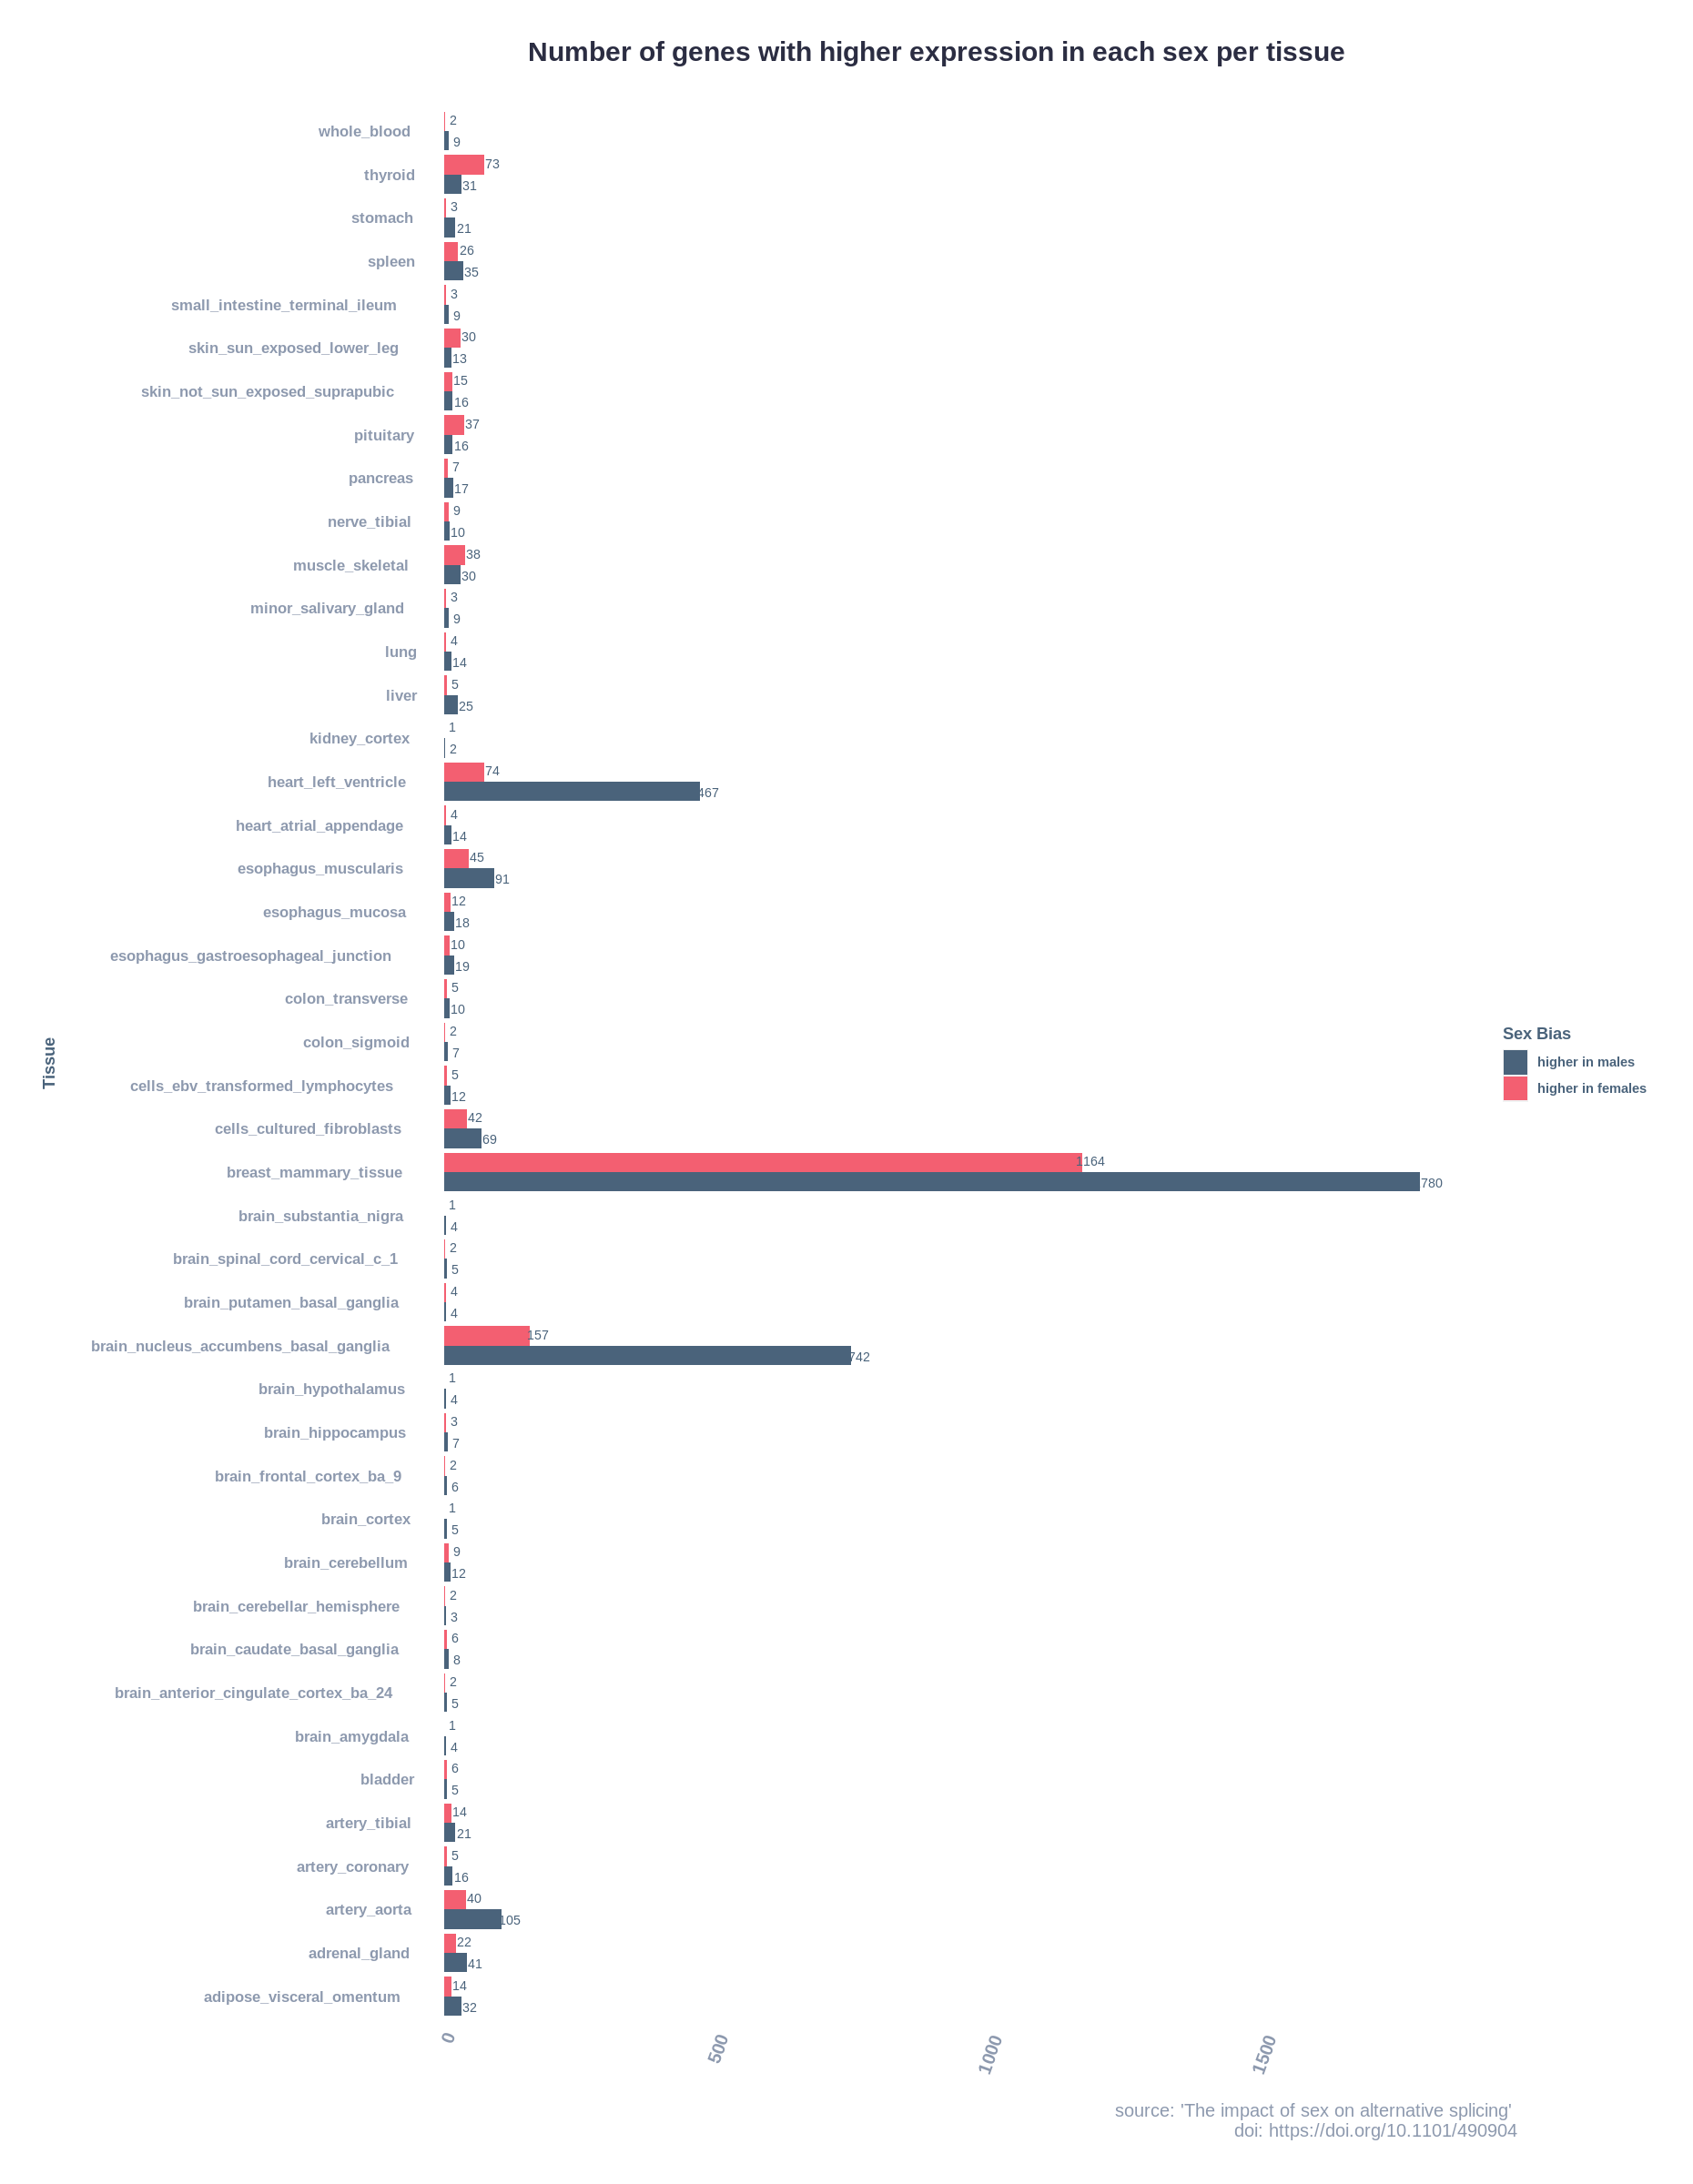

In [47]:
options(repr.plot.width=15.5, repr.plot.height=20)

ggplot(toPlot, aes(x = Tissue, y = `Number of Genes`, fill = `Sex Bias`)) + 
  geom_bar(stat="identity", position = "dodge") + 
  scale_fill_manual (values = c( "higher in males" = "#4A637B" , "higher in females" = "#f35f71")) + 
  
  theme(text              = element_text(color = "#4A637B", face = "bold", family = 'Helvetica')
        ,plot.caption     = element_text(size =  12, color = "#8d99ae", face = "plain", hjust= 1.05) 
        ,plot.title       = element_text(size =  18, color = "#2b2d42", face = "bold", hjust= 0.5)
        ,axis.text.y      = element_text(angle =  0, size = 10, color = "#8d99ae", face = "bold", hjust=1.1)
        ,axis.text.x      = element_text(angle = 70, size = 12, color = "#8d99ae", face = "bold", hjust=1.1)
        ,axis.title.x     = element_blank()
        ,axis.ticks.x     = element_blank()
        ,axis.ticks.y     = element_blank()
        ,plot.margin      = unit(c(1,1,1,1),"cm")
        ,panel.background = element_blank()
        ,legend.position  = "right") +
  

  geom_text(aes(y = `Number of Genes` + 15, 
                label = `Number of Genes`),
                size = 3,
                color     = "#4A637B",
                position  =  position_dodge(width = 1),
                family    = 'Helvetica') +
  
  labs(title   = "Number of genes with higher expression in each sex per tissue\n",
       caption = "\nsource: 'The impact of sex on alternative splicing'\n doi: https://doi.org/10.1101/490904",
       y   = "\nNumber of Differentially Expressed Genes")  + coord_flip()



# Mutually exclusive sex biased genes (higher expression in one or the other sex only)


The dataframe `signif_per_tissue` contains all the information for the genes that were significantly higher in either of the two sexes. WLet's examine how many mutually exclusive genes were found across all examined tissues. Ensembl encodes as `Chromosome` the chromosomal position, so we will create the required variables to retrieve only the chromosome information for producing summary statistics.

In [59]:
dput(colnames(signif_per_tissue))
t(head(signif_per_tissue$chr,1))

c("logFC", "AveExpr", "t", "P.Value", "adj.P.Val", "B", "junctionGeneSymbol", 
"symbol", "ID", "splice_type", "featurespace", "GeneID", "geneSymbol", 
"chr", "strand", "exonStart_0base", "exonEnd", "upstreamES", 
"upstreamEE", "downstreamES", "downstreamEE", "abs_logFC", "FoldChange_dummy", 
"abundance", "tissue")


[,1]
[1,] chrX
24 Levels: chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 ... chrY

In [74]:
chromosome_column <- "chr"
signif_per_tissue$Chromosome <-  signif_per_tissue[[chromosome_column]]
signif_per_tissue$higher_in  <- 0
signif_per_tissue$higher_in[(signif_per_tissue$abundance == "lower" )] <- "males"
signif_per_tissue$higher_in[(signif_per_tissue$abundance == "higher" )] <- "females"
toKeepInOrder <- colnames(signif_per_tissue)
signif_per_tissue <- signif_per_tissue[, toKeepInOrder]
head(signif_per_tissue)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,junctionGeneSymbol,symbol,ID,splice_type,⋯,upstreamEE,downstreamES,downstreamEE,abs_logFC,FoldChange_dummy,abundance,tissue,Chromosomal_Position,Chromosome,higher_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>
1,-7.142389,0.9941613,-48.325871,1.260076e-177,5.353307e-173,324.02755,XIST-10149,XIST,10149,SE,⋯,73829231,73833237,73833374,7.142389,-141.277585,lower,adipose_visceral_omentum,chrX,chrX,males
2,-6.826079,0.7901787,-46.608288,7.328131e-172,1.556642e-167,316.71971,XIST-10154,XIST,10154,SE,⋯,73829231,73833237,73833374,6.826079,-113.463031,lower,adipose_visceral_omentum,chrX,chrX,males
3,6.584646,0.8340215,43.521422,3.869817e-161,5.480177e-157,297.70972,XIST-10152,XIST,10152,SE,⋯,73829231,73831065,73831210,6.584646,95.978957,higher,adipose_visceral_omentum,chrX,chrX,females
4,-2.887104,1.5312931,-21.602020,5.515682e-71,5.858206e-67,138.21741,XIST-10150,XIST,10150,SE,⋯,73831274,73837439,73841474,2.887104,-7.397839,lower,adipose_visceral_omentum,chrX,chrX,males
5,-1.661346,1.3748820,-11.289854,4.058754e-26,3.448643e-22,46.00144,XIST-10155,XIST,10155,SE,⋯,73821029,73826114,73827984,1.661346,-3.163114,lower,adipose_visceral_omentum,chrX,chrX,males
6,-1.360720,1.2477198,-9.942836,3.870273e-21,2.740411e-17,35.51915,XIST-10151,XIST,10151,SE,⋯,73821029,73826114,73826301,1.360720,-2.568132,lower,adipose_visceral_omentum,chrX,chrX,males


# Examine mutually exclusive genes upregulated in each sex

In [75]:
feature_id_column <- "junctionGeneSymbol"
female_biased <- unique(signif_per_tissue[[feature_id_column]] [ signif_per_tissue$higher_in == "females" ] )
male_biased   <- unique(signif_per_tissue[[feature_id_column]] [ signif_per_tissue$higher_in == "males"  ] )

length(male_biased)
length(female_biased)

[1] 3202

[1] 1725

In [76]:
## Present in both

length((intersect(male_biased, female_biased)))
length((intersect(female_biased, male_biased)))

intersect <- (intersect(male_biased, female_biased))


[1] 82

[1] 82

In [77]:
## Only in males
length(male_biased[! (male_biased %in% intersect)])

## Only females
length(female_biased[! (female_biased %in% intersect)])

[1] 3120

[1] 1643

In [98]:
perc_only_male <-  length(male_biased[! (male_biased %in% intersect)]) / length(male_biased) * 100
perc_only_female <-  length(female_biased[! (female_biased %in% intersect)]) / length(female_biased) * 100

head( signif_per_tissue[ signif_per_tissue[[feature_id_column]] %in% male_biased[! (male_biased %in% intersect)],  ] , 4 )

message(round(perc_only_male, 2), " % of differentially spliced exons higher in males only found to be significantly different in males")
message(round(perc_only_female,2), " % of differentially spliced exon higher in females only found to be significantly different in females")

,logFC,AveExpr,t,P.Value,adj.P.Val,B,junctionGeneSymbol,symbol,ID,splice_type,⋯,upstreamEE,downstreamES,downstreamEE,abs_logFC,FoldChange_dummy,abundance,tissue,Chromosomal_Position,Chromosome,higher_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<fct>
1,-7.142389,0.9941613,-48.32587,1.260076e-177,5.353307e-173,324.02755,XIST-10149,XIST,10149,SE,⋯,73829231,73833237,73833374,7.142389,-141.277585,lower,adipose_visceral_omentum,chrX,chrX,males
2,-6.826079,0.7901787,-46.60829,7.328131e-172,1.556642e-167,316.71971,XIST-10154,XIST,10154,SE,⋯,73829231,73833237,73833374,6.826079,-113.463031,lower,adipose_visceral_omentum,chrX,chrX,males
4,-2.887104,1.5312931,-21.60202,5.515682e-71,5.858206e-67,138.21741,XIST-10150,XIST,10150,SE,⋯,73831274,73837439,73841474,2.887104,-7.397839,lower,adipose_visceral_omentum,chrX,chrX,males
5,-1.661346,1.3748820,-11.28985,4.058754e-26,3.448643e-22,46.00144,XIST-10155,XIST,10155,SE,⋯,73821029,73826114,73827984,1.661346,-3.163114,lower,adipose_visceral_omentum,chrX,chrX,males


97.44 % of differentially spliced exons higher in males only found to be significantly different in males

95.25 % of differentially spliced exon higher in females only found to be significantly different in females



## Significantly higher only in males

In [83]:
dim(signif_per_tissue[ signif_per_tissue[[feature_id_column]] %in% male_biased[! (male_biased %in% intersect)],  ])
only_male_genes <- signif_per_tissue[ signif_per_tissue[[feature_id_column]] %in% (male_biased[! (male_biased %in% intersect)]) ,  ]
head(only_male_genes[ order(only_male_genes[[feature_id_column]] ), ], 5)

[1] 3685   28

,logFC,AveExpr,t,P.Value,adj.P.Val,B,junctionGeneSymbol,symbol,ID,splice_type,⋯,upstreamEE,downstreamES,downstreamEE,abs_logFC,FoldChange_dummy,abundance,tissue,Chromosomal_Position,Chromosome,higher_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>
4073,-0.5955568,1.1637530,-3.642049,2.994282e-04,3.110246e-02,0.1551172,AASDH-8358,AASDH,8358,SE,⋯,56355423,56378147,56378464,0.5955568,-1.511056,lower,heart_left_ventricle,chr4,chr4,males
5872,-0.6126833,0.6789157,-3.463742,5.796545e-04,4.178827e-02,-0.4196361,AASDH-8360,AASDH,8360,SE,⋯,56378464,56384069,56384341,0.6126833,-1.529101,lower,heart_left_ventricle,chr4,chr4,males
5382,-0.7787639,1.0601134,-3.504982,5.002924e-04,3.943307e-02,-0.2999951,ABAT-41977,ABAT,41977,SE,⋯,8735809,8748107,8748137,0.7787639,-1.715660,lower,heart_left_ventricle,chr16,chr16,males
859,-0.8384955,-0.3239752,-3.348290,9.464875e-04,4.643253e-02,-0.8086289,ABCA10-25861,ABCA10,25861,SE,⋯,69174394,69175405,69175513,0.8384955,-1.788184,lower,brain_nucleus_accumbens_basal_ganglia,chr17,chr17,males
1548,-0.7583276,1.5568773,-4.834672,1.926925e-06,5.322723e-05,4.4191048,ABCA10-25861,ABCA10,25861,SE,⋯,69174394,69175405,69175513,0.7583276,-1.691529,lower,breast_mammary_tissue,chr17,chr17,males


In [91]:
# See 8.1.1 enquo() and !! - Quote and unquote arguments in https://tidyeval.tidyverse.org/dplyr.html

only_male_genes %>% 
    count( symbol, sort = TRUE) %>%
    head(20)

symbol,n
<chr>,<int>
XIST,219
ZFX,47
DDX3X,42
KDM6A,27
APOL4,14
CD44,13
JPX,13
NLRP2,12
ST5,12


## Significantly higher only in females

In [94]:
only_female_genes <- signif_per_tissue[ signif_per_tissue[[ feature_id_column ]] %in% (female_biased[! (female_biased %in% intersect)]) ,  ]

head(only_female_genes[ order(only_female_genes[[ feature_id_column ]] ), ], 10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,junctionGeneSymbol,symbol,ID,splice_type,⋯,upstreamEE,downstreamES,downstreamEE,abs_logFC,FoldChange_dummy,abundance,tissue,Chromosomal_Position,Chromosome,higher_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>
11710,0.8803741,0.3023067,4.196745,3.226225e-05,1.163931e-02,2.1350264,ABAT-41980,ABAT,41980,SE,⋯,8674711,8735698,8735809,0.8803741,1.840853,higher,heart_left_ventricle,chr16,chr16,females
3358,0.9091782,-0.4053210,3.615421,3.394816e-04,4.254435e-03,-0.3757219,ABCC11-17034,ABCC11,17034,SE,⋯,48175417,48176923,48177113,0.9091782,1.877976,higher,breast_mammary_tissue,chr16,chr16,females
7311,1.8927812,0.9691542,10.248417,5.750013e-22,3.346350e-19,39.1486527,ABCC3-16865,ABCC3,16865,SE,⋯,50634981,50655831,50656008,1.8927812,3.713504,higher,breast_mammary_tissue,chr17,chr17,females
271,0.7674558,-0.6612006,4.600703,6.182539e-06,9.728111e-03,3.5721400,ABCC4-27454,ABCC4,27454,SE,⋯,95161335,95163121,95163216,0.7674558,1.702265,higher,adrenal_gland,chr13,chr13,females
4240,0.7445919,0.5219909,3.284179,1.115909e-03,1.104316e-02,-1.4502800,ABCC6-26306,ABCC6,26306,SE,⋯,16161564,16165622,16165933,0.7445919,1.675500,higher,breast_mammary_tissue,chr16,chr16,females
286,0.7590254,1.4010146,3.782868,1.966159e-04,2.916162e-02,0.5489584,ABHD5-32771,ABHD5,32771,SE,⋯,43702587,43711708,43711863,0.7590254,1.692347,higher,brain_nucleus_accumbens_basal_ganglia,chr3,chr3,females
7221,0.7222673,4.4496722,6.153304,1.895667e-09,1.112369e-07,11.0999336,ABI1-35906,ABI1,35906,SE,⋯,26770345,26777064,26777241,0.7222673,1.649773,higher,breast_mammary_tissue,chr10,chr10,females
927,1.0114000,3.0435614,3.311033,1.075573e-03,4.857090e-02,-0.9204755,ABI2-32213,ABI2,32213,SE,⋯,203367044,203380207,203380277,1.0114000,2.015866,higher,brain_nucleus_accumbens_basal_ganglia,chr2,chr2,females
5802,0.7110850,0.3636750,2.812708,5.162843e-03,3.620040e-02,-2.7360676,ABI3BP-29700,ABI3BP,29700,SE,⋯,100862385,100864001,100864076,0.7110850,1.637035,higher,breast_mammary_tissue,chr3,chr3,females


In [95]:
only_female_genes %>% 
    count( symbol, sort = TRUE) %>%
    head(20)

symbol,n
<chr>,<int>
XIST,44
KDM5C,37
DHCR24,10
SELE,10
HPGD,9
NDRG4,9
PUDP,8
SORBS1,8
ANK3,7


# Examine number of differentially expressed genes per chromosome per sex

In [96]:
signif_per_tissue$Chromosome <- as.factor(signif_per_tissue$Chromosome)
signif_per_tissue$higher_in <- as.factor(signif_per_tissue$higher_in)

signif_per_tissue %>% 
    group_by(Chromosome,higher_in) %>%  
    count()  -> signif_per_chrom_per_sex

In [97]:
signif_per_chrom_per_sex

Chromosome,higher_in,n
<fct>,<fct>,<int>
chr1,females,200
chr1,males,355
chr10,females,70
chr10,males,88
chr11,females,117
chr11,males,250
chr12,females,107
chr12,males,220
chr13,females,17


## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [ ]:
notebook_id   = "summary_per_tissue_diff_expressed"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data/ && sha256sum **/*csv > ../metadata/", notebook_id, "_sha256sums.txt"), intern = TRUE)
system(paste0("cd ../data/ && sha256sum *csv >> ../metadata/", notebook_id, "_sha256sums.txt"), intern = TRUE)

message("Done!\n")

data.table::fread(paste0("../metadata/", notebook_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

### 2. Libraries metadata

In [ ]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebook_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebook_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

# Calculating the sex-biased splicing index
The normalized sex-biased splicing index is defined as the number of statistically significant splicing events per 1000 exons in the chromosome.

In [ ]:
dim(signif_per_chrom_per_sex)

Sorry, I cannot do this in R. Here is Python (ugly script but works)

import csv
import gzip
import re
from collections import defaultdict

fname = 'Homo_sapiens.GRCh38.100.chr_patch_hapl_scaff.gtf.gz'

chrom2exons = defaultdict(set)

with gzip.open(fname, 'rt') as f:
    cr = csv.reader(f, delimiter='\t', quotechar='"')
    for row in cr:
        #print(row)
        if row[0].startswith('#'):
            continue
        chrom = row[0]
        annots = row[8]
        fields = annots.split(";")
        exon = re.compile(r'exon_id "(ENSE\d+)"')
        for f in fields:
            itm = f.strip()
            match = exon.match(itm)
            if match:
                exonid = match.group(1)
                chrom2exons[chrom].add(exonid)

g = open('chrom2exons.txt', 'wt')
for k, v in chrom2exons.items():
    print("chr{}: n={}".format(k, len(v)))
    g.write("{}\t{}\n".format(k, len(v)))
g.close()

1	69381
2	55599
3	46452
4	29749
5	34789
6	33817
7	35973
X	22471
8	28489
9	26460
11	43212
10	26514
12	42925
13	13193
14	25994
15	28720
16	36285
17	45142
18	13360
20	16704
19	44166
Y	2908
22	16411
21	8830
MT	37

In [ ]:
signif_per_chrom_per_sex

In [ ]:
only_female_genes %>% 
    count( !!GENE_ID, GeneSymbol, Class, sort = TRUE) %>%
    head(20)

In [ ]:
signif_per_tissue %>% 
     group_by(Chromosome) %>%  
    count()  -> signif_per_chrom

In [ ]:
signif_per_chrom

In [ ]:
chrom2exon_filename = '../assets/canon_chrom2exons.txt'
if (! file.exists(chrom2exon_filename)) {
    message("Could not find canon_chrom2exons.txt file")
}
c2e_df = read.csv(chrom2exon_filename, sep='\t', header=FALSE)
colnames(c2e_df) <- c("Chromosome","exons")
head(c2e_df) # 25 chromosomes including MT

In [ ]:
df2 <- merge(signif_per_chrom, c2e_df, by="Chromosome")
head(df2)

In [ ]:
# calculate splicinig index
library(tidyverse)

In [ ]:
df2 %>% 
  mutate(Index = 1000 * n/exons) -> df3

In [ ]:
df4 <- df3[-25,] # remove the Y chromosome
df4 <- df4[-23,] # remove the MT chromosome

In [ ]:
res_sorted <- df4[order(df4$Index, decreasing=TRUE),]
res_sorted


In [ ]:
res_sorted$Chromosome <- factor(res_sorted$Chromosome, levels = res_sorted$chr)
res_sorted

In [ ]:
# set the colors
npgBlue<- rgb(60/256,84/256,136/256,1)
npgRed <- rgb(220/256,0,0,0.5)
npgGreen <- rgb(0,160/256,135/256,1)
npgBrown <- rgb(126/256,97/256,72/256,1)

In [ ]:
# make the plot 
figure2b <- ggplot(res_sorted, aes(x = Chromosome, y = Index, size = n)) +
  geom_point(color=npgBlue) +
  theme_bw() +
  theme(axis.text.x = element_text(size=14, angle = 270, hjust = 0.0, vjust = 0.5),
	axis.text.y = element_text(size=16),
	axis.title.x = element_blank(),
	axis.title.y = element_text(face="plain", colour="black",
                                    size=18),
	legend.title=element_blank(),
	legend.text = element_text(face="plain", colour="black",
                                   size=14)) +
  scale_fill_viridis_c() +
  ylab(paste("Sex-biased splicing index ")) +
  xlab("Chromosomes") +
  guides(size = guide_legend(title = "Number of ASE"))
figure2b
